In [1]:
! pip install pytrends

In [2]:
! pip install pmdarima

# Indicator of War in Ukraine

In [4]:
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt

# Googel Trends query

In [3]:
from pytrends.request import TrendReq

In [29]:
keywords = ['Ukraine War', 'Russia War', 'Crimea', 'Donbas Conflict', 'Ukraine invasion']
pytrend = TrendReq(hl='en-GB', tz=360,geo ='US' )
pytrend.build_payload( kw_list=keywords,  timeframe= '2010-01-01 2022-12-31')
data = pytrend.interest_over_time()

In [30]:
data.drop(columns =["isPartial"], inplace = True)
data.reset_index(inplace =  True, drop = False)

In [31]:
data

,date,Ukraine War,Russia War,Crimea,Donbas Conflict,Ukraine invasion
0,2010-01-01,0,3,0,0,0
1,2010-02-01,0,3,1,0,0
2,2010-03-01,0,4,1,0,0
3,2010-04-01,0,5,0,0,0
4,2010-05-01,0,3,1,0,0
...,...,...,...,...,...,...
140,2021-09-01,0,2,1,0,0
141,2021-10-01,0,2,1,0,0
142,2021-11-01,0,2,1,0,0
143,2021-12-01,1,4,2,0,1


In [32]:
data.columns

Index(['date', 'Ukraine War', 'Russia War', 'Crimea', 'Donbas Conflict',
       'Ukraine invasion'],
      dtype='object')

# Plot

In [34]:
#change this for my indicator
fig = px.line(data, x="date", y=['Ukraine War', 'Russia War', 'Crimea', 'Donbas Conflict',
       'Ukraine invasion'])
fig.show()

# Hodrick & Prescott + ARIMA

In [39]:
import statsmodels.api as sm

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=101.843, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-246.986, Time=0.53 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-235.935, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-280.538, Time=0.78 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-293.354, Time=3.10 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-291.392, Time=4.87 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=-291.231, Time=3.18 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-292.905, Time=2.21 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=7.47 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=41.229, Time=0.83 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=-529.172, Time=4.42 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-526.040, Time=2.46 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=-529.086, Time=6.74 sec
 ARIMA(2,1,0)(3,1,1)[12]        

,Ukraine War,log_Ukraine War,cycle_Ukraine War,trend_Ukraine War
0,0.01,-4.605170,-0.000008,-4.605162
1,0.01,-4.605170,-0.000010,-4.605160
2,0.01,-4.605170,-0.000012,-4.605158
3,0.01,-4.605170,-0.000014,-4.605156
4,0.01,-4.605170,-0.000014,-4.605156
...,...,...,...,...
140,0.01,-4.605170,-1.426677,-3.178493
141,0.01,-4.605170,-1.809456,-2.795714
142,0.01,-4.605170,-2.363293,-2.241877
143,1.00,0.000000,1.552844,-1.552844


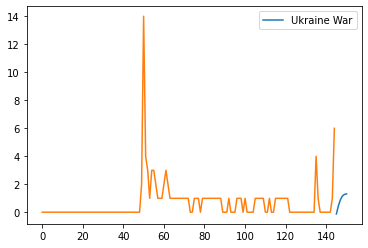

In [50]:
#crear un dataframe preliminar para pegarle resultados
columna = 'Ukraine War'
df = data[[columna]].dropna()

df[columna] = df[columna].replace(0, 0.01)
#Se saca el logaritmo natural
df['log_' + columna] = np.log(df[columna])
#Se aplica el filtro
df['cycle_'+ columna], df['trend_'+ columna] = sm.tsa.filters.hpfilter(df['log_'+columna], 50)

#se escogen los datos para el modelo arima
inp = df["trend_"+columna]

n = len(inp) - 6
train=inp[:n]
test=inp[n:]
model = auto_arima(inp.dropna(),start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=200)

n_forecast = 6
forecast_index = np.array(range(test.index[-1] + 1, test.index[-1] + n_forecast+1)) #revisar que sea solo train
prediction = pd.DataFrame(model.predict(n_periods = n_forecast), index=forecast_index)
#prediction = pd.DataFrame(model.predict(n_periods = n_forecast), index=test.index)
#prediction.reset_index(inplace = True, drop = True)
prediction.columns = [columna]
df_base = prediction
df_base.plot()
df[columna].plot()

### Loop para cada variable

In [53]:
columnas = data.columns

# Corregir este FOR ----------------

In [54]:
from tqdm import tqdm
for columna in tqdm(columnas[2:]):
    df = data[[columna]].dropna()

    df[columna] = df[columna].replace(0, 0.01)
    #Se saca el logaritmo natural
    df['log_' + columna] = np.log(df[columna])
    #Se aplica el filtro
    df['cycle_'+ columna], df['trend_'+ columna] = sm.tsa.filters.hpfilter(df['log_'+columna], 50)

    #se escogen los datos para el modelo arima
    inp = df["trend_"+columna]

    n = len(inp) - 6
    train=inp[:n]
    test=inp[n:]
    model = auto_arima(inp.dropna(),start_p=0,d=1,start_q=0,
              max_p=5,max_d=5,max_q=5, start_P=0,
              D=1, start_Q=0, max_P=5,max_D=5,
              max_Q=5, m=12, seasonal=True,
              error_action='warn',trace=True,
              supress_warnings=True,stepwise=True,
              random_state=20,n_fits=200)

    n_forecast = 6
    forecast_index = np.array(range(test.index[-1] + 1, test.index[-1] + n_forecast+1)) #revisar que sea solo train
    prediction = pd.DataFrame(model.predict(n_periods = n_forecast), index=forecast_index)
    #prediction = pd.DataFrame(model.predict(n_periods = n_forecast), index=test.index)
    #prediction.reset_index(inplace = True, drop = True)
    prediction.columns = [columna]
    df_base_temp = prediction
    df_base = pd.concat([df_base, df_base_temp])

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-389.787, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-707.038, Time=0.51 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-695.249, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-715.940, Time=1.76 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-717.908, Time=4.57 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-716.789, Time=6.67 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=-716.751, Time=3.99 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-723.626, Time=2.15 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=2.99 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.45 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=8.24 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-428.235, Time=1.03 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=-

 17%|██████████████                                                                      | 1/6 [01:15<06:19, 75.91s/it]

 ARIMA(3,1,0)(2,1,0)[12] intercept   : AIC=-977.681, Time=3.51 sec

Best model:  ARIMA(3,1,0)(2,1,0)[12]          
Total fit time: 75.827 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=39.716, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-356.095, Time=0.64 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-317.068, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-393.816, Time=1.26 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-407.003, Time=1.88 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-405.904, Time=5.28 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=-406.305, Time=3.93 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-407.849, Time=2.62 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-401.546, Time=0.59 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=-406.007, Time=3.05 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=2.40 sec
 ARIMA(1,1,0)(3,1,2

 33%|███████████████████████████▋                                                       | 2/6 [08:29<19:04, 286.18s/it]

 ARIMA(3,1,0)(4,1,0)[12] intercept   : AIC=-647.368, Time=13.29 sec

Best model:  ARIMA(3,1,0)(4,1,0)[12]          
Total fit time: 433.235 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2938.241, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-2655.717, Time=0.57 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-3181.846, Time=1.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-2936.241, Time=0.25 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-3165.760, Time=0.81 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-3271.204, Time=2.91 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-2920.262, Time=1.92 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=-2930.241, Time=2.24 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=-3292.097, Time=5.15 sec


C:\Users\danie\anaconda3\envs\risk\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(0,1,1)(2,1,3)[12]             : AIC=-2617.067, Time=1.96 sec
 ARIMA(0,1,1)(1,1,4)[12]             : AIC=-2926.241, Time=4.49 sec
 ARIMA(0,1,1)(0,1,4)[12]             : AIC=-2928.241, Time=3.77 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-2580.969, Time=2.83 sec
 ARIMA(0,1,1)(2,1,4)[12]             : AIC=-2924.241, Time=5.06 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=-3294.097, Time=4.27 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=-2932.241, Time=0.94 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-2922.262, Time=1.23 sec


C:\Users\danie\anaconda3\envs\risk\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(0,1,0)(2,1,3)[12]             : AIC=-2619.067, Time=1.54 sec
 ARIMA(0,1,0)(1,1,4)[12]             : AIC=-2928.241, Time=1.93 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-2940.390, Time=1.62 sec
 ARIMA(0,1,0)(0,1,4)[12]             : AIC=-2930.241, Time=3.22 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=-2586.495, Time=2.20 sec
 ARIMA(0,1,0)(2,1,4)[12]             : AIC=-2926.241, Time=2.31 sec


C:\Users\danie\anaconda3\envs\risk\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(1,1,0)(1,1,3)[12]             : AIC=-2651.444, Time=0.82 sec
 ARIMA(1,1,1)(1,1,3)[12]             : AIC=-2666.645, Time=3.83 sec


 50%|█████████████████████████████████████████▌                                         | 3/6 [09:33<09:14, 184.67s/it]

 ARIMA(0,1,0)(1,1,3)[12] intercept   : AIC=-2526.744, Time=6.43 sec

Best model:  ARIMA(0,1,0)(1,1,3)[12]          
Total fit time: 63.799 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-68.407, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-253.994, Time=1.41 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-255.105, Time=1.16 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-250.958, Time=0.90 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-253.008, Time=4.00 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=5.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-255.759, Time=1.44 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=inf, Time=5.16 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=-251.400, Time=8.12 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-97.532, Time=0.78 sec
 ARIMA(1,1,1)(0,1,2)[12]    

 67%|███████████████████████████████████████████████████████▎                           | 4/6 [11:29<05:15, 157.58s/it]C:\Users\danie\anaconda3\envs\risk\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

invalid value encountered in log

 67%|███████████████████████████████████████████████████████▎                           | 4/6 [11:29<05:44, 172.30s/it]

 ARIMA(2,1,1)(0,1,1)[12] intercept   : AIC=-789.324, Time=2.38 sec

Best model:  ARIMA(2,1,1)(0,1,1)[12]          
Total fit time: 115.971 seconds


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

## Merge Forecast and History

In [57]:
data['Type'] = 'Historic'
df_base['Type'] = 'Forecast'

# FX Rates Latam

In [59]:
import investpy

In [60]:
currencies = ["USD/COP", "USD/MXN", "USD/BRL", "USD/ARS", "USD/CLP", "USD/UYU", 
              "USD/DOP"]

countries = ["Colombia", "Mexico", "Brazil", "Argentina", "Chile", "Uruguay", 
             "Dominican Republic"]

In [83]:
start_date = '01/01/2004'
end_date = '31/12/2022'



df_tc = investpy.get_currency_cross_historical_data(currency_cross=currencies[0],
                                                 from_date=start_date,
                                                 to_date=end_date).reset_index(drop = False)[['Date', 'Close']]
                                     

df_tc["Country"] = countries[0]
len(df_tc)

4717

In [84]:
for curr, country in zip(currencies[1:], countries[1:]):
    df_temp  = investpy.get_currency_cross_historical_data(currency_cross=curr,
                                                 from_date=start_date,
                                                 to_date=end_date).reset_index(drop = False)[['Date', 'Close']]
    df_temp["Country"] = country
    df_tc = pd.concat([df_tc,df_temp])

In [99]:
df_tc["Country"].unique()

array(['Colombia', 'Mexico', 'Brazil', 'Argentina', 'Chile', 'Uruguay',
       'Dominican Republic'], dtype=object)

In [100]:
df_tc["Month"] = df_tc["Date"].dt.to_period("M")

In [101]:
df_tc["FX"] = "FX_" + df_tc["Country"]
df_tc_wide = df_tc.pivot_table(index = ["Month"], columns = "FX", values = ["Close"]).reset_index()
df_tc_wide.columns = df_tc_wide.columns.get_level_values(1)

df_tc_wide.rename(columns={"":"Month"}, inplace = True)
tc_log_vars = df_tc_wide.columns[1:]

In [102]:
tc_log_vars

Index(['FX_Argentina', 'FX_Brazil', 'FX_Chile', 'FX_Colombia',
       'FX_Dominican Republic', 'FX_Mexico', 'FX_Uruguay'],
      dtype='object', name='FX')

In [103]:
df_tc_wide.set_index('Month', inplace = True)
for col in tc_log_vars:
    df_tc_wide['Pct_' + col] = df_tc_wide[col].pct_change(periods = 1)

In [104]:
df_tc_wide

FX,FX_Argentina,FX_Brazil,FX_Chile,FX_Colombia,FX_Dominican Republic,FX_Mexico,FX_Uruguay,Pct_FX_Argentina,Pct_FX_Brazil,Pct_FX_Chile,Pct_FX_Colombia,Pct_FX_Dominican Republic,Pct_FX_Mexico,Pct_FX_Uruguay
Month,,,,,,,,,,,,,,
2004-01,2.891429,2.851019,573.373810,2750.882381,44.080952,10.925948,29.387143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02,2.926275,2.929000,583.905000,2715.826500,47.500000,11.041550,29.509000,0.012052,0.027352,0.018367,-0.012744,0.077563,0.010581,0.004147
2004-03,2.896522,2.903565,605.294348,2671.612174,45.758696,11.015730,29.627174,-0.010168,-0.008684,0.036632,-0.016280,-0.036659,-0.002338,0.004005
2004-04,2.832768,2.905682,607.879545,2641.647727,43.550000,11.272605,29.656364,-0.022010,0.000729,0.004271,-0.011216,-0.048268,0.023319,0.000985
2004-05,2.915819,3.105119,637.082381,2728.008571,46.900000,11.515533,29.778095,0.029318,0.068637,0.048040,0.032692,0.076923,0.021550,0.004105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10,99.164650,5.538590,813.662857,3765.509048,56.344524,20.439833,43.534286,0.010174,0.049695,0.035173,-0.014036,-0.004873,0.019822,0.020038
2021-11,100.253773,5.557164,813.497273,3902.245000,56.510455,20.867764,44.005455,0.010983,0.003353,-0.000204,0.036313,0.002945,0.020936,0.010823
2021-12,101.860217,5.653539,849.391739,3974.255652,56.901304,20.876709,44.304348,0.016024,0.017343,0.044124,0.018454,0.006916,0.000429,0.006792


In [105]:
df_tc_wide.columns

Index(['FX_Argentina', 'FX_Brazil', 'FX_Chile', 'FX_Colombia',
       'FX_Dominican Republic', 'FX_Mexico', 'FX_Uruguay', 'Pct_FX_Argentina',
       'Pct_FX_Brazil', 'Pct_FX_Chile', 'Pct_FX_Colombia',
       'Pct_FX_Dominican Republic', 'Pct_FX_Mexico', 'Pct_FX_Uruguay'],
      dtype='object', name='FX')

In [106]:
df_tc_pct = df_tc_wide[['Pct_FX_Argentina',
       'Pct_FX_Brazil', 'Pct_FX_Chile', 'Pct_FX_Colombia',
       'Pct_FX_Dominican Republic', 'Pct_FX_Mexico', 'Pct_FX_Uruguay']]

## Merge Google and FX

In [65]:
data['Month'] =  data['date'].dt.to_period("M")

In [69]:
data.columns

Index(['date', 'Ukraine War', 'Russia War', 'Crimea', 'Donbas Conflict',
       'Ukraine invasion', 'cycle_Ukraine War', 'trend_Ukraine War', 'Type',
       'Month'],
      dtype='object')

In [73]:
df_google = data[['Month','Ukraine War', 'Russia War', 'Crimea', 'Donbas Conflict',
       'Ukraine invasion']]
#df_google.set_index('Month', inplace = True)
#for col in df_google.columns[1:]:
#    df_google['Pct_' + col] = df_google[col].pct_change(periods = 1)

In [107]:
df_merge = df_google.merge(df_tc_pct, how="inner", left_on ="Month", right_on = "Month")

In [108]:
df_merge

,Month,Ukraine War,Russia War,Crimea,Donbas Conflict,Ukraine invasion,Pct_FX_Argentina,Pct_FX_Brazil,Pct_FX_Chile,Pct_FX_Colombia,Pct_FX_Dominican Republic,Pct_FX_Mexico,Pct_FX_Uruguay
0,2010-01,0,3,0,0,0,-0.000600,0.015955,-0.002097,-0.020619,-0.000025,-0.001754,-0.005981
1,2010-02,0,3,1,0,0,0.011879,0.034586,0.060174,-0.014085,0.003036,0.007707,0.006741
2,2010-03,0,4,1,0,0,0.003473,-0.030461,-0.016983,-0.021237,0.003529,-0.028308,-0.001647
3,2010-04,0,5,0,0,0,0.003338,-0.016195,-0.005271,0.016557,0.004546,-0.026336,-0.017405
4,2010-05,0,3,1,0,0,0.006308,0.033011,0.026928,0.023075,0.006482,0.043020,-0.005330
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2021-09,0,2,1,0,0,0.010769,0.004964,0.006957,-0.015399,-0.006714,-0.001116,-0.012619
141,2021-10,0,2,1,0,0,0.010174,0.049695,0.035173,-0.014036,-0.004873,0.019822,0.020038
142,2021-11,0,2,1,0,0,0.010983,0.003353,-0.000204,0.036313,0.002945,0.020936,0.010823
143,2021-12,1,4,2,0,1,0.016024,0.017343,0.044124,0.018454,0.006916,0.000429,0.006792


<AxesSubplot:>

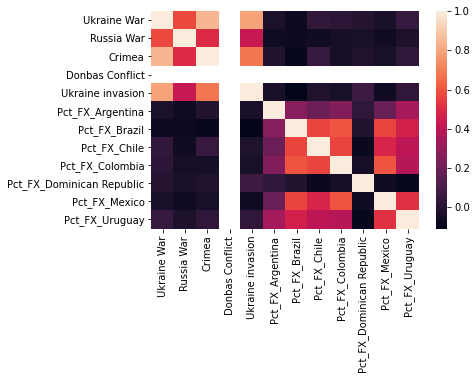

In [109]:
import seaborn as sns
df_corr = df_merge.corr()
sns.heatmap(df_corr)